In [1]:
iterations=2, learning_rate=1, depth=2, loss_function='MultiClass'import pandas as pd
pd.options.display.max_columns = 200

import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Exploring the data

Data: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

In [2]:
problem = 'PumpItUp'
train = pd.read_csv('data/' + problem + '/train.csv')
labels = pd.read_csv('data/' + problem + '/train_labels.csv')
test = pd.read_csv('data/' + problem + '/test.csv')

In [36]:
def stats():
    display(train.head())
    #display(test.head(1))
    #display(labels.head(1))

    train_nulls = train.isnull().sum()
    test_nulls = test.isnull().sum()
    nulls = pd.concat([train_nulls[train_nulls != 0], 
                       test_nulls[test_nulls != 0]], axis=1)
    nulls.columns = ['train', 'test']
    
    display(nulls)
    display(train.describe())

In [37]:
stats()

,id,amount_tsh,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded
0,69572,6000.0,funder_OTHER,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1,4,2,0
1,8776,0.0,funder_OTHER,installer_OTHER,34.698766,-2.147466,Lake Victoria,Mara,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1,6,2,0
2,34310,25.0,funder_OTHER,installer_OTHER,37.460664,-3.821329,Pangani,Manyara,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1,5,1,0
3,67743,0.0,Unicef,installer_OTHER,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,True,VWC,True,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,3,0,0
4,19728,0.0,funder_OTHER,installer_OTHER,31.130847,-1.825359,Lake Victoria,Kagera,True,,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,0


,train,test


,id,amount_tsh,longitude,latitude,construction_year,construction_date_known,construction_decade
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,34.077427,-5.706033e+00,892.655471,0.651364,2.767879
std,21453.128371,2997.574558,6.567432,2.946019e+00,995.294508,0.476543,2.266691
min,0.000000,0.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,34.908743,-5.021597e+00,0.000000,1.000000,3.000000
75%,55656.500000,20.000000,37.178387,-3.326156e+00,2004.000000,1.000000,5.000000
max,74247.000000,350000.000000,40.345193,-2.000000e-08,2012.000000,1.000000,6.000000


# Preprocessing

In [5]:
def reduce_factor_levels(df, column_name, limit=None, top=None, name=None):
    assert(limit is not None or top is not None), 'Specify limit ot top'
    if top is None:
        top = df[column_name].value_counts()[:limit].index
    if name is None:
        name = '%s_OTHER' % column_name
    df.loc[~df[column_name].isin(top), column_name] = name
    return top

In [6]:
top = reduce_factor_levels(train, 'funder', 10)
reduce_factor_levels(test, 'funder', top=top);

top = reduce_factor_levels(train, 'installer', 10)
reduce_factor_levels(test, 'installer', top=top);

In [7]:
min_year = train[train.construction_year > 0].construction_year.min() // 10 - 1

heights = np.arange(-1, train.gps_height.max()+500, 500)
height_labels = list(range(len(heights)-1))

pops = np.arange(-1, train.population.max()+500, 500)
pops_labels = list(range(len(pops)-1))

def preprocess(df):
    df.scheme_management.fillna('Unknown', inplace=True)
    
    #df['construction_date_known'] = (df.construction_year > 0).astype(np.int32)
    #df['construction_decade'] = df.construction_year // 10 - min_year
    #df.loc[df.construction_decade < 0, 'construction_decade'] = 0

    df.loc[df.extraction_type == 'other - mkulima/shinyanga', 'extraction_type'] = 'other'
    
    #df['gps_height_rounded'] = pd.cut(df.gps_height, bins=heights, labels=height_labels)
    #df['pop_rounded'] = pd.cut(df.population, bins=pops, labels=pops_labels)

    bool_to_str = lambda x str(x) if isinstance(x, bool) else 'Unknown'
    df.public_meeting = df.public_meeting.apply(bool_to_str)
    df.permit = df.permit.apply(bool_to_str)
    
    med_height = df.gps_height
    df.gps_height.fillna(0, inplace=True)
    
    drop = ['wpt_name', 'num_private', 'subvillage', 'region_code', 'date_recorded',\
            'district_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'population']    
    df.drop(drop, axis=1, inplace=True)

In [8]:
preprocess(train)
preprocess(test)

In [9]:
top = reduce_factor_levels(train, 'construction_year', 20, name=0)
reduce_factor_levels(test, 'construction_year', top=top, name=0);

In [10]:
stats()

,id,amount_tsh,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded
0,69572,6000.0,funder_OTHER,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1,4,2,0


,id,amount_tsh,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded
0,50785,0.0,funder_OTHER,installer_OTHER,35.290799,-4.059696,Internal,Manyara,True,Parastatal,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1,6,3,0


,id,status_group
0,69572,functional


,train,test


# Visualizing the data

https://public.tableau.com/profile/calin.uioreanu#!/vizhome/DataMiningtheWaterTableDrivenData_com/Bubblestatusquantity

# Preparing the data for fitting

In [11]:
from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(labels['status_group'])

In [21]:
def prepare(X_train, X_test):
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.feature_extraction import DictVectorizer
    
    objects = X_train.select_dtypes(include=['O']).columns.values
    numeric = X_train.select_dtypes(exclude=['O']).columns.values
    
    #display(X_train[objects])
    
    #dv = DictVectorizer(sparse=False)
    dv = LabelEncoder()
    data_encoded_tr = pd.DataFrame()
    data_encoded_ts = pd.DataFrame()
    
    for col in objects:
        data_encoded_tr[col] = dv.fit_transform(X_train[col]) #.to_dict(orient='records'))
        data_encoded_ts[col] = dv.transform(X_test[col]) #.to_dict(orient='records'))

    ss = StandardScaler()
    data_scaled_tr = ss.fit_transform(X_train[numeric])
    data_scaled_ts = ss.transform(X_test[numeric])
    
    train = np.hstack((data_encoded_tr, data_scaled_tr))
    test  = np.hstack((data_encoded_ts, data_scaled_ts))
    return train, test

In [28]:
tmp = train.drop(['id'], axis=1)
cat_feat = np.where(np.array([dt == object for dt in tmp.dtypes]))[0]
features = tmp.columns

In [23]:
X, X_test = prepare(tmp, test.drop(['id'], axis=1))

In [24]:
# fix random seed for reproducibility
import numpy as np
seed = 7
np.random.seed(seed)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=seed)

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [800], # , , 120 500, 300, 800
    'max_depth': [15], # , 5, 8, , None 30,, 25
    'min_samples_split': [5], # , 10, 100 15, 2, 
    'min_samples_leaf': [2], # ,10,1 , 5
    'max_features': ['log2'] #, None 'sqrt',
}

forest = GridSearchCV(RandomForestClassifier(), 
                      param_grid=params, 
                      scoring='accuracy', 
                      verbose=10, n_jobs=-1)
forest.fit(X, y);

print('Best params: ', forest.best_params_)
print('Best score: ', forest.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5 
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5 
[CV] max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5 
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5, score=0.789192, total= 1.2min
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5, score=0.789040, total= 1.5min
[CV]  max_depth=15, max_features=log2, min_samples_leaf=2, n_estimators=800, min_samples_split=5, score=0.793939, total= 1.6min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


Best params:  {'max_depth': 15, 'n_estimators': 800, 'min_samples_leaf': 2, 'max_features': 'log2', 'min_samples_split': 5}
Best score:  0.790723905724


Feature ranking:
1. management (0.122403)
2. management_group (0.118946)
3. source (0.075566)
4. source_type (0.068673)
5. quality_group (0.061575)
6. quantity (0.054366)
7. public_meeting (0.039324)
8. waterpoint_type_group (0.034942)
9. quantity_group (0.034287)
10. longitude (0.030029)
11. region (0.028905)
12. construction_decade (0.028855)
13. basin (0.027084)
14. construction_year (0.026874)
15. amount_tsh (0.024616)
16. extraction_type (0.023361)
17. installer (0.022781)
18. payment (0.022321)
19. scheme_management (0.021112)
20. latitude (0.019605)
21. payment_type (0.017495)
22. funder (0.016660)
23. gps_height_rounded (0.014358)
24. extraction_type_group (0.010573)
25. extraction_type_class (0.010162)
26. permit (0.009476)
27. waterpoint_type (0.009131)
28. water_quality (0.008033)
29. construction_date_known (0.006774)
30. source_class (0.006386)
31. pop_rounded (0.005326)


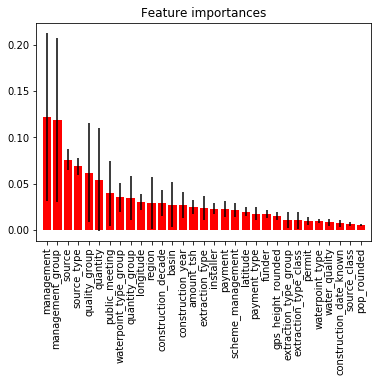

In [17]:
importances = forest.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
mapper = np.vectorize(lambda x: features[x])
plt.xticks(range(X.shape[1]), mapper(indices), rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Cat Boost

In [35]:
import catboost
cbc = catboost.CatBoostClassifier(loss_function='MultiClass')
cbc.fit(X_train, 
        y_train, 
        verbose=True, 
        eval_set=[X_validation, y_validation],
        cat_feat=)
cbc.score(X_validation, y_validation)

Borders generated
0:	learn -1.077303554	test -1.07767036	bestTest -1.07767036	passed: 0.388 sec	total: 4.43s	remaining: 36m 50s
1:	learn -1.057269641	test -1.057919174	bestTest -1.057919174	passed: 0.407 sec	total: 4.84s	remaining: 20m 4s
2:	learn -1.038415599	test -1.039351163	bestTest -1.039351163	passed: 0.413 sec	total: 5.25s	remaining: 14m 29s
3:	learn -1.020869272	test -1.021974207	bestTest -1.021974207	passed: 0.41 sec	total: 5.66s	remaining: 11m 41s
4:	learn -1.004713121	test -1.006105287	bestTest -1.006105287	passed: 0.419 sec	total: 6.08s	remaining: 10m 1s
5:	learn -0.9898467119	test -0.9914306906	bestTest -0.9914306906	passed: 0.409 sec	total: 6.49s	remaining: 8m 54s
6:	learn -0.9757344312	test -0.9774931349	bestTest -0.9774931349	passed: 0.407 sec	total: 6.9s	remaining: 8m 5s
7:	learn -0.9621773989	test -0.964264021	bestTest -0.964264021	passed: 0.412 sec	total: 7.31s	remaining: 7m 29s
8:	learn -0.9485954182	test -0.9508276594	bestTest -0.9508276594	passed: 0.379 sec	total:

72:	learn -0.6821786201	test -0.6894945991	bestTest -0.6894945991	passed: 0.427 sec	total: 37.1s	remaining: 3m 36s
73:	learn -0.6810126117	test -0.6883742771	bestTest -0.6883742771	passed: 0.425 sec	total: 37.5s	remaining: 3m 35s
74:	learn -0.6797224775	test -0.6871579089	bestTest -0.6871579089	passed: 0.407 sec	total: 37.9s	remaining: 3m 34s
75:	learn -0.678641401	test -0.6861612793	bestTest -0.6861612793	passed: 0.406 sec	total: 38.3s	remaining: 3m 33s
76:	learn -0.6778066942	test -0.6853487088	bestTest -0.6853487088	passed: 0.4 sec	total: 38.7s	remaining: 3m 32s
77:	learn -0.6765984862	test -0.6841865991	bestTest -0.6841865991	passed: 0.427 sec	total: 39.1s	remaining: 3m 31s
78:	learn -0.6756387941	test -0.6832776984	bestTest -0.6832776984	passed: 0.415 sec	total: 39.5s	remaining: 3m 30s
79:	learn -0.6744402861	test -0.6821600959	bestTest -0.6821600959	passed: 0.409 sec	total: 40s	remaining: 3m 29s
80:	learn -0.6732312449	test -0.6809956997	bestTest -0.6809956997	passed: 0.417 sec	t

144:	learn -0.6315211473	test -0.6418014458	bestTest -0.6418014458	passed: 0.427 sec	total: 1m 6s	remaining: 2m 43s
145:	learn -0.6311213282	test -0.6414007479	bestTest -0.6414007479	passed: 0.379 sec	total: 1m 7s	remaining: 2m 42s
146:	learn -0.6307345045	test -0.6410423738	bestTest -0.6410423738	passed: 0.41 sec	total: 1m 7s	remaining: 2m 42s
147:	learn -0.63041392	test -0.6407477324	bestTest -0.6407477324	passed: 0.486 sec	total: 1m 8s	remaining: 2m 41s
148:	learn -0.6297820183	test -0.6401764101	bestTest -0.6401764101	passed: 0.664 sec	total: 1m 8s	remaining: 2m 41s
149:	learn -0.6293868774	test -0.6397709743	bestTest -0.6397709743	passed: 0.77 sec	total: 1m 9s	remaining: 2m 42s
150:	learn -0.6289554042	test -0.6393126414	bestTest -0.6393126414	passed: 0.748 sec	total: 1m 10s	remaining: 2m 42s
151:	learn -0.6283464123	test -0.6387722316	bestTest -0.6387722316	passed: 0.59 sec	total: 1m 10s	remaining: 2m 42s
152:	learn -0.6277651802	test -0.6381914626	bestTest -0.6381914626	passed: 

215:	learn -0.6064858922	test -0.6190633317	bestTest -0.6190633317	passed: 0.432 sec	total: 1m 40s	remaining: 2m 11s
216:	learn -0.6060584651	test -0.6186826975	bestTest -0.6186826975	passed: 0.406 sec	total: 1m 40s	remaining: 2m 11s
217:	learn -0.6058061751	test -0.6184707921	bestTest -0.6184707921	passed: 0.415 sec	total: 1m 41s	remaining: 2m 10s
218:	learn -0.6056412393	test -0.6183277545	bestTest -0.6183277545	passed: 0.399 sec	total: 1m 41s	remaining: 2m 10s
219:	learn -0.6053924477	test -0.6181393713	bestTest -0.6181393713	passed: 0.407 sec	total: 1m 41s	remaining: 2m 9s
220:	learn -0.605106853	test -0.6178337587	bestTest -0.6178337587	passed: 0.398 sec	total: 1m 42s	remaining: 2m 9s
221:	learn -0.6048383695	test -0.6176268314	bestTest -0.6176268314	passed: 0.401 sec	total: 1m 42s	remaining: 2m 8s
222:	learn -0.6045975049	test -0.6173743138	bestTest -0.6173743138	passed: 0.424 sec	total: 1m 43s	remaining: 2m 8s
223:	learn -0.6042358733	test -0.6170393879	bestTest -0.6170393879	pa

286:	learn -0.5892866508	test -0.6043451358	bestTest -0.6043451358	passed: 0.545 sec	total: 2m 11s	remaining: 1m 37s
287:	learn -0.588959545	test -0.604082064	bestTest -0.604082064	passed: 0.463 sec	total: 2m 11s	remaining: 1m 36s
288:	learn -0.5888567808	test -0.6039897986	bestTest -0.6039897986	passed: 0.46 sec	total: 2m 12s	remaining: 1m 36s
289:	learn -0.5887051121	test -0.6038675991	bestTest -0.6038675991	passed: 0.509 sec	total: 2m 12s	remaining: 1m 36s
290:	learn -0.5884694931	test -0.6037046964	bestTest -0.6037046964	passed: 0.468 sec	total: 2m 13s	remaining: 1m 35s
291:	learn -0.5880782929	test -0.6033687463	bestTest -0.6033687463	passed: 0.464 sec	total: 2m 13s	remaining: 1m 35s
292:	learn -0.5878533001	test -0.6031498036	bestTest -0.6031498036	passed: 0.454 sec	total: 2m 14s	remaining: 1m 34s
293:	learn -0.5875748377	test -0.6029525926	bestTest -0.6029525926	passed: 0.582 sec	total: 2m 14s	remaining: 1m 34s
294:	learn -0.5873525424	test -0.6027358511	bestTest -0.6027358511	p

357:	learn -0.5756566106	test -0.5928309746	bestTest -0.5928309746	passed: 0.524 sec	total: 2m 43s	remaining: 1m 4s
358:	learn -0.5754776312	test -0.5927159769	bestTest -0.5927159769	passed: 0.43 sec	total: 2m 43s	remaining: 1m 4s
359:	learn -0.5752467289	test -0.5924880878	bestTest -0.5924880878	passed: 0.392 sec	total: 2m 44s	remaining: 1m 3s
360:	learn -0.5751291671	test -0.5923864691	bestTest -0.5923864691	passed: 0.4 sec	total: 2m 44s	remaining: 1m 3s
361:	learn -0.574989525	test -0.5922967528	bestTest -0.5922967528	passed: 0.519 sec	total: 2m 45s	remaining: 1m 2s
362:	learn -0.5748114958	test -0.5921447885	bestTest -0.5921447885	passed: 0.387 sec	total: 2m 45s	remaining: 1m 2s
363:	learn -0.5746595795	test -0.5919914181	bestTest -0.5919914181	passed: 0.397 sec	total: 2m 45s	remaining: 1m 2s
364:	learn -0.5743814777	test -0.591789187	bestTest -0.591789187	passed: 0.452 sec	total: 2m 46s	remaining: 1m 1s
365:	learn -0.5742865325	test -0.5917106216	bestTest -0.5917106216	passed: 0.4

429:	learn -0.564139583	test -0.5836076473	bestTest -0.5836076473	passed: 0.496 sec	total: 3m 14s	remaining: 31.7s
430:	learn -0.5640049785	test -0.5835105561	bestTest -0.5835105561	passed: 0.447 sec	total: 3m 15s	remaining: 31.3s
431:	learn -0.5638212359	test -0.5834144362	bestTest -0.5834144362	passed: 0.418 sec	total: 3m 15s	remaining: 30.8s
432:	learn -0.5637160818	test -0.5833531112	bestTest -0.5833531112	passed: 0.538 sec	total: 3m 16s	remaining: 30.4s
433:	learn -0.56362674	test -0.5832576389	bestTest -0.5832576389	passed: 0.505 sec	total: 3m 16s	remaining: 29.9s
434:	learn -0.5634879709	test -0.5831381189	bestTest -0.5831381189	passed: 0.602 sec	total: 3m 17s	remaining: 29.5s
435:	learn -0.5633458566	test -0.5830186526	bestTest -0.5830186526	passed: 0.594 sec	total: 3m 18s	remaining: 29.1s
436:	learn -0.5631811078	test -0.5828933862	bestTest -0.5828933862	passed: 0.415 sec	total: 3m 18s	remaining: 28.6s
437:	learn -0.5630538705	test -0.5827931642	bestTest -0.5827931642	passed: 

0.76178451178451179

In [ ]:
y_test1 = cbc1.predict(prepr1.transform(X_test))
ans1 = pd.DataFrame({'id': X_test.iloc[:,0], 'status_group': y_test1})
ans1.to_csv('ans1.csv')

# LightGBM

In [32]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

gbm = lgb.LGBMClassifier()
gbm.fit(X_train, y_train)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_validation, num_iteration=gbm.best_iteration)
# eval
print('Accuracy of prediction is:', accuracy_score(y_validation, y_pred))

print('Calculate feature importances...')
# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Start predicting...
Accuracy of prediction is: 0.739983164983
Calculate feature importances...
Feature importances: [0.039999999, 0.028888889, 0.033333335, 0.082222223, 0.02111111, 0.02111111, 0.016666668, 0.059999999, 0.055555556, 0.007777778, 0.04222222, 0.014444444, 0.0099999998, 0.0011111111, 0.1, 0.0, 0.048888888, 0.031111112, 0.0055555557, 0.065555558, 0.0, 0.007777778, 0.093333334, 0.077777781, 0.015555556, 0.015555556, 0.050000001, 0.0099999998, 0.026666667, 0.017777778, 0.0]
